# Install Importance Sampling module for Keras

In [2]:
# Install Dependency
!pip3 install blinker

# Clone Repo
!pip install --user keras-importance-sampling
!git clone https://github.com/idiap/importance-sampling.git
  
# Convert the repo into a module for usage in the notebook
!touch importance-sampling/__init__.py
!touch importance-sampling/importance_sampling/__init__.py
!touch importance-sampling/examples/__init__.py
!cp -r importance-sampling/* .

# Copy contents of repo for easy usage 
!cp -r importance-sampling/* .

     |████████████████████████████████| 112kB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/92/a0/00/8690a57883956a301d91cf4ec999cc0b258b01e3f548f86e89
Successfully built blinker
     |████████████████████████████████| 40kB 3.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/04/0c/09/53a134f3839e74f2d11d755f06452734e919d049c6737b0c36
Successfully built keras-importance-sampling
Cloning into 'importance-sampling'...
remote: Enumerating objects: 799, done.
remote: Total 799 (delta 0), reused 0 (delta 0), pack-reused 799
Receiving objects: 100% (799/799), 1.00 MiB | 13.32 MiB/s, done.
Resolving deltas: 100% (551/551), done.


# Imports

In [31]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
import numpy as np

import time

from keras import backend as K
from keras.callbacks import LearningRateScheduler, Callback
from keras.datasets import cifar10
from keras.layers import Activation, BatchNormalization, Conv2D, Dense, \
    GlobalAveragePooling2D, Input, add
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.models import load_model

from importance_sampling.datasets import CIFAR10, ZCAWhitening
from importance_sampling.models import wide_resnet
from importance_sampling.training import ImportanceTraining
from examples.example_utils import get_parser
from importance_sampling.layers.normalization import LayerNormalization

import matplotlib.pyplot as plt

from IPython.display import Image, display
from google.colab import files

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Wide Resnet Baseline on CIFAR 10

## Helper Classes

In [0]:
class TrainingSchedule(Callback):
    """Implement the training schedule for training a resnet on CIFAR10 for a
    given time budget."""
    def __init__(self, total_time):
        self._total_time = total_time
        self._lr = self._get_lr(0.0)

    def _get_lr(self, progress):
        if progress > 0.8:
            return 0.004
        elif progress > 0.5:
            return 0.02
        else:
            return 0.1

    def on_train_begin(self, logs={}):
        self._start = time.time()
        self._lr = self._get_lr(0.0)
        K.set_value(self.model.optimizer.lr, self._lr)

    def on_batch_end(self, batch, logs):
        t = time.time() - self._start

        if t >= self._total_time:
            self.model.stop_training = True

        lr = self._get_lr(t / self._total_time)
        if lr != self._lr:
            self._lr = lr
            K.set_value(self.model.optimizer.lr, self._lr)

    @property
    def lr(self):
        return self._lr

class Args():
  def __init__(self, depth, width, presample, batch_size, time_budget, dropout, useIS):
    self.depth = depth
    self.width = width
    self.presample = presample
    self.batch_size = batch_size
    self.time_budget = 3600*time_budget
    self.dropout = dropout
    self.importance_training = useIS

## Load Dataset

In [0]:
# Load Dataset
dset = ZCAWhitening(CIFAR10())

170500096/170498071 [==============================] - 51s 0us/step


## Model Utility Functions

### Build Model

In [0]:
def build_model(args, dset):
  training_schedule = TrainingSchedule(args.time_budget)
  model = wide_resnet(args.depth, args.width, args.dropout)(dset.shape, dset.output_size)
  model.compile(
      loss="categorical_crossentropy",
      optimizer=SGD(lr=training_schedule.lr, momentum=0.9),
      metrics=["accuracy"]
  )
  model.summary()
  return model, training_schedule

### Train Model

In [0]:
def train_model(model, args, x_train, y_train, x_test, y_test, training_schedule):
  # Create the data augmentation generator
  datagen = ImageDataGenerator(
      # set input mean to 0 over the dataset
      featurewise_center=False,
      # set each sample mean to 0
      samplewise_center=False,
      # divide inputs by std of dataset
      featurewise_std_normalization=False,
      # divide each input by its std
      samplewise_std_normalization=False,
      # apply ZCA whitening
      zca_whitening=False,
      # randomly rotate images in the range (deg 0 to 180)
      rotation_range=0,
      # randomly shift images horizontally
      width_shift_range=0.1,
      # randomly shift images vertically
      height_shift_range=0.1,
      # randomly flip images
      horizontal_flip=True,
      # randomly flip images
      vertical_flip=False)
  datagen.fit(x_train)

  # Train the model
  if args.importance_training:
      history = ImportanceTraining(model).fit_generator(
          datagen.flow(x_train, y_train, batch_size=args.batch_size),
          validation_data=(x_test, y_test),
          epochs=10**6,
          verbose=1,
          callbacks=[training_schedule],
          batch_size=args.batch_size,
          steps_per_epoch=int(np.ceil(float(len(x_train)) / args.batch_size))
      )
  else:
      history = model.fit_generator(
          datagen.flow(x_train, y_train, batch_size=args.batch_size),
          validation_data=(x_test, y_test),
          epochs=10**6,
          verbose=1,
          callbacks=[training_schedule],
          steps_per_epoch=int(np.ceil(float(len(x_train)) / args.batch_size))
      )
  return model, history

### Evaluate Model

In [0]:
# Score trained model.
def eval_model(model, x_test, y_test):
  scores = model.evaluate(x_test, y_test, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])

### Wrapper 

In [0]:
def build_wide_res(args, dset):
  # Split dataset
  x_train, y_train = dset.train_data[:]
  x_test, y_test = dset.test_data[:]

  model, training_schedule = build_model(args, dset)
  model, history = train_model(model, args, x_train, y_train, x_test, y_test, training_schedule)
  return model, history

### Saving the model and plots to Drive

In [0]:
def save_model(model, file_name):
  path = "gdrive/My Drive/"
  model.save(path + file_name + '.h5')
  
def save_plots(model, history, file_name, useIS):
  path = "gdrive/My Drive/" + file_name
  
  # Hack for a minor annoyance
  if useIS:
    acc = history.history['accuracy'][:-1]
    val_acc = history.history['val_accuracy'][:-1]
  else:
    acc = history.history['acc'][:-1]
    val_acc = history.history['val_acc'][:-1]
    
  # summarize history for accuracy
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(path + "-acc.png")
  plt.show()

  # summarize history for loss
  plt.plot(history.history['loss'][:-1])
  plt.plot(history.history['val_loss'][:-1])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(path + "-loss.png")
  plt.show()
  
def save_history(history, file_name, useIS):
  path = "gdrive/My Drive/" + file_name + "-history"
  
  if useIS:
    acc_hist = np.array(history.history['accuracy'][:-1])
    val_acc_hist = np.array(history.history['val_accuracy'][:-1])
  else:
    acc_hist = np.array(history.history['acc'][:-1])
    val_acc_hist = np.array(history.history['val_acc'][:-1])
    
  loss_hist = np.array(history.history['loss'][:-1])
  val_loss_hist = np.array(history.history['val_loss'][:-1])
  
  np.save(path, np.vstack((acc_hist, val_acc_hist, loss_hist, val_loss_hist)))
  
  
def save(model, history, file_name, useIS):
  save_model(model, file_name)
  save_plots(model, history, file_name, useIS)
  save_history(history, file_name, useIS)

## Evaluation

### Wide ResNet 28-2 with 0.3 dropout and max time of 1 hr (with IS)

In [0]:
args = Args(depth = 28, width = 2, presample = 3.0, batch_size = 128, time_budget = 1, dropout = 0.3, useIS = True)
model, history = build_wide_res(args, dset)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 32, 32, 16)   432         input_7[0][0]                    
__________________________________________________________________________________________________
layer_normalization_101 (LayerN (None, 32, 32, 16)   17          conv2d_113[0][0]                 
__________________________________________________________________________________________________
activation_105 (Activation)     (None, 32, 32, 16)   0           layer_normalization_101[0][0]    
__________________________________________________________________________________________________
conv2d_114

[NOTICE]: You are using BatchNormalization and/or Dropout.
Those layers may affect the importance calculations and you are advised to exchange them for LayerNormalization or BatchNormalization in test mode and L2 regularization.


Epoch 1/1000000
391/391 [==============================] - 68s 174ms/step - loss: 2.8522 - accuracy: 0.1453 - val_loss: 1.9877 - val_accuracy: 0.2095
Epoch 2/1000000
391/391 [==============================] - 63s 161ms/step - loss: 2.1884 - accuracy: 0.2686 - val_loss: 1.8400 - val_accuracy: 0.2976
Epoch 3/1000000
391/391 [==============================] - 62s 160ms/step - loss: 1.9094 - accuracy: 0.3422 - val_loss: 1.7465 - val_accuracy: 0.3611
Epoch 4/1000000
391/391 [==============================] - 63s 160ms/step - loss: 1.7519 - accuracy: 0.3947 - val_loss: 1.5387 - val_accuracy: 0.4187
Epoch 5/1000000
391/391 [==============================] - 63s 160ms/step - loss: 1.6205 - accuracy: 0.4541 - val_loss: 1.4186 - val_accuracy: 0.4756
Epoch 6/1000000
391/391 [==============================] - 62s 159ms/step - loss: 1.4923 - accuracy: 0.5095 - val_loss: 1.1426 - val_accuracy: 0.5807
Epoch 7/1000000
391/391 [==============================] - 62s 160ms/step - loss: 1.4237 - accuracy:

In [0]:
# Test the model
x_test, y_test = dset.test_data[:]
eval_model(model, x_test, y_test)

10000/10000 [==============================] - 6s 568us/step
Test loss: 0.5215594121217728
Test accuracy: 0.8974


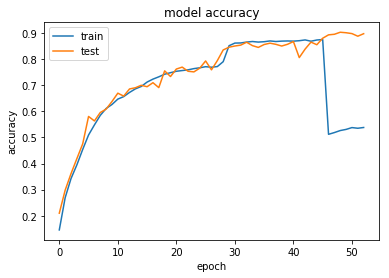

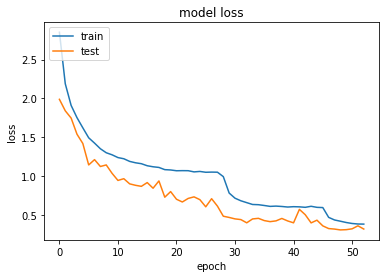

In [0]:
# Save model
save(model, history, 'res-net-28-2-1hr-dropout-IS', True)

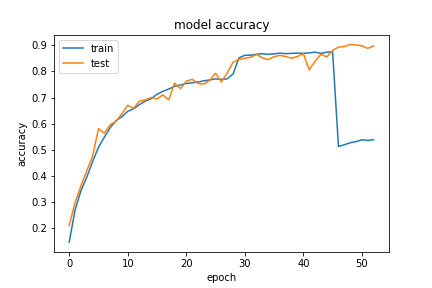

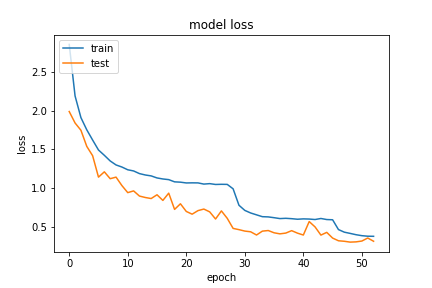

In [0]:
# Load model and draw plots 
path = "gdrive/My Drive/"
file_name = "res-net-28-2-1hr-dropout-IS"
model = load_model(path + file_name + ".h5", custom_objects = {'LayerNormalization' : LayerNormalization})

# Display Saved plots
listOfImageNames = [path + file_name + "-acc.png",
                    path + file_name + "-loss.png"]

for imageName in listOfImageNames:
    display(Image(filename=imageName))
    
# Load history
history = np.load(path + file_name + "-history.npy")

### Wide ResNet 28-2 with 0.3 dropout and max time of 1 hr (without IS)

In [0]:
args = Args(depth = 28, width = 2, presample = 3.0, batch_size = 128, time_budget = 1, dropout = 0.3, useIS = False)
model, history = build_wide_res(args, dset)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 32, 32, 16)   432         input_6[0][0]                    
__________________________________________________________________________________________________
layer_normalization_76 (LayerNo (None, 32, 32, 16)   17          conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_79 (Activation)      (None, 32, 32, 16)   0           layer_normalization_76[0][0]     
__________________________________________________________________________________________________
conv2d_86 

In [0]:
# Test the model
x_test, y_test = dset.test_data[:]
eval_model(model, x_test, y_test)

10000/10000 [==============================] - 3s 259us/step
Test loss: 0.5106745192527771
Test accuracy: 0.9017


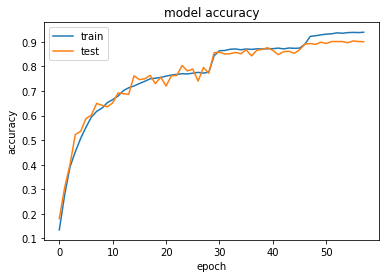

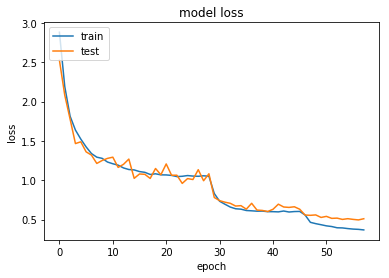

In [0]:
# Save model
save(model, history, 'res-net-28-2-1hr-dropout-noIS', False)

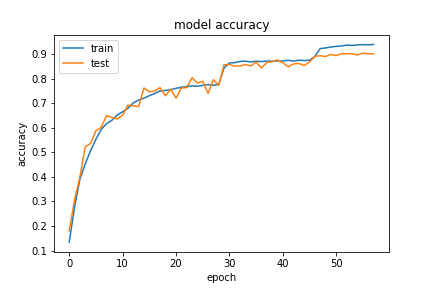

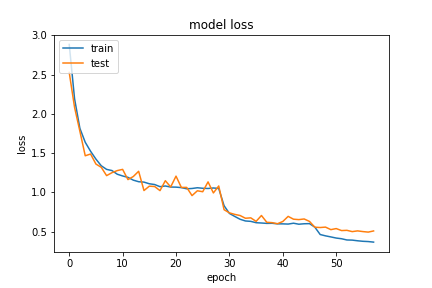

In [0]:
# Load model and draw plots 
path = "gdrive/My Drive/"
file_name = "res-net-28-2-1hr-dropout-noIS"
model = load_model(path + file_name + ".h5", custom_objects = {'LayerNormalization' : LayerNormalization})

# Display Saved plots
listOfImageNames = [path + file_name + "-acc.png",
                    path + file_name + "-loss.png"]

for imageName in listOfImageNames:
    display(Image(filename=imageName))
    
# Load history
history = np.load(path + file_name + "-history.npy")

### Wide ResNet 28-2 without dropout and max time of 1 hr (with IS)

In [0]:
args = Args(depth = 28, width = 2, presample = 3.0, batch_size = 128, time_budget = 1, dropout = 0, useIS = True)
model, history = build_wide_res(args, dset)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 16)   432         input_2[0][0]                    
__________________________________________________________________________________________________
layer_normalization_26 (LayerNo (None, 32, 32, 16)   17          conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 32, 32, 16)   0           layer_normalization_26[0][0]     
__________________________________________________________________________________________________
conv2d_30 

In [0]:
# Test the model
x_test, y_test = dset.test_data[:]
eval_model(model, x_test, y_test)

10000/10000 [==============================] - 3s 264us/step
Test loss: 0.5321150021553039
Test accuracy: 0.9062


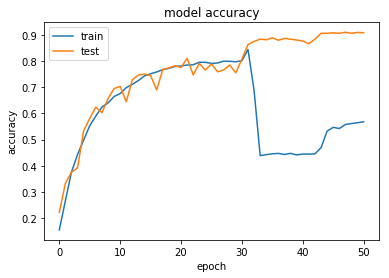

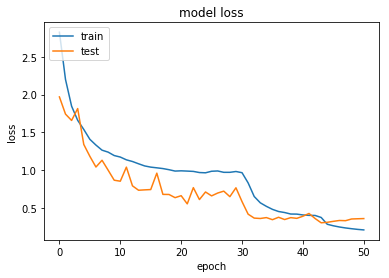

In [0]:
# Save model, plots and history
save(model, history, 'res-net-28-2-1hr-nodropout-IS', True)

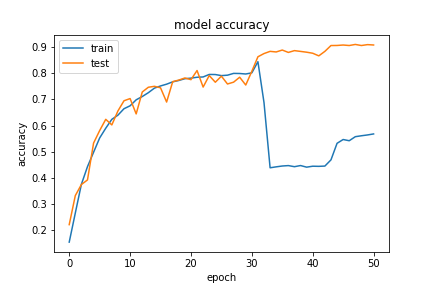

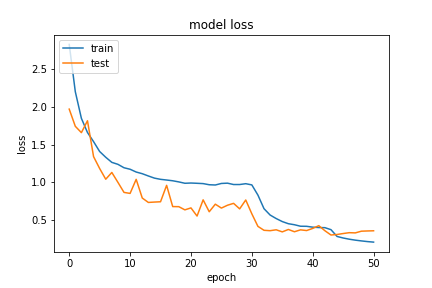

In [0]:
# Load model and draw plots 
path = "gdrive/My Drive/"
file_name = "res-net-28-2-1hr-nodropout-IS"
model = load_model(path + file_name + ".h5", custom_objects = {'LayerNormalization' : LayerNormalization})

# Display Saved plots
listOfImageNames = [path + file_name + "-acc.png",
                    path + file_name + "-loss.png"]

for imageName in listOfImageNames:
    display(Image(filename=imageName))
    
# Load history
history = np.load(path + file_name + "-history.npy")

### Wide ResNet 28-2 without dropout and max time of 1 hr (without IS)

In [0]:
args = Args(depth = 28, width = 2, presample = 3.0, batch_size = 128, time_budget = 1, dropout = 0, useIS = False)
model, history = build_wide_res(args, dset)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 32, 32, 16)   432         input_5[0][0]                    
__________________________________________________________________________________________________
layer_normalization_51 (LayerNo (None, 32, 32, 16)   17          conv2d_57[0][0]                  
__________________________________________________________________________________________________
activation_53 (Activation)      (None, 32, 32, 16)   0           layer_normalization_51[0][0]     
__________________________________________________________________________________________________
conv2d_58 

In [0]:
# Test the model
x_test, y_test = dset.test_data[:]
eval_model(model, x_test, y_test)

10000/10000 [==============================] - 3s 256us/step
Test loss: 0.5064974669933319
Test accuracy: 0.9089


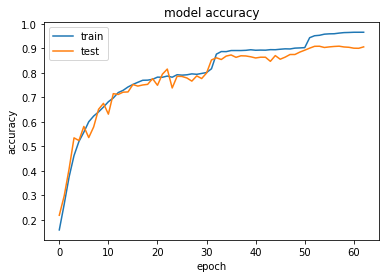

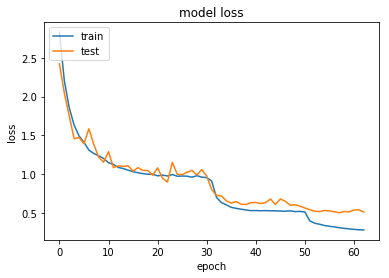

In [0]:
# Save model, plots and history
save(model, history, 'res-net-28-2-1hr-nodropout-noIS', False)

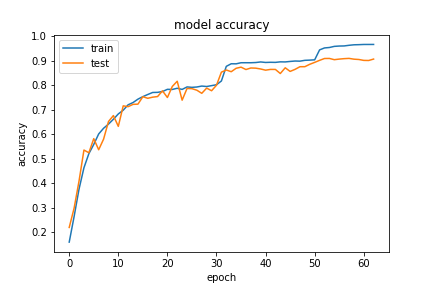

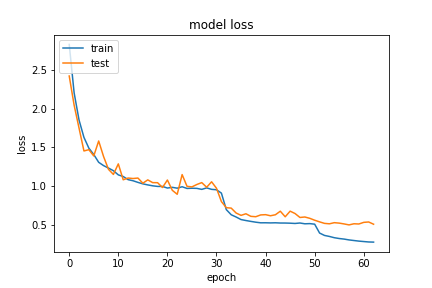

In [0]:
# Load model and draw plots 
path = "gdrive/My Drive/"
file_name = "res-net-28-2-1hr-nodropout-noIS"
model = load_model(path + file_name + ".h5", custom_objects = {'LayerNormalization' : LayerNormalization})

# Display Saved plots
listOfImageNames = [path + file_name + "-acc.png",
                    path + file_name + "-loss.png"]

for imageName in listOfImageNames:
    display(Image(filename=imageName))
    
# Load history
history = np.load(path + file_name + "-history.npy")

# Models for Embeddings

In [0]:
args = Args(depth = 28, width = 2, presample = 3.0, batch_size = 128, time_budget = 1, dropout = 0, useIS = False)
model, history = build_wide_res(args, dset)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 16)   432         input_4[0][0]                    
__________________________________________________________________________________________________
layer_normalization_26 (LayerNo (None, 32, 32, 16)   17          conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 32, 32, 16)   0           layer_normalization_26[0][0]     
__________________________________________________________________________________________________
conv2d_30 

In [0]:
D = CIFAR10()

In [0]:
a,b = D.train_data[:]

In [0]:
a[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

## Super Res model

In [36]:
from importance_sampling.datasets import InMemoryImageDataset
from keras.datasets import cifar10
from functools import partial

# Load dataset
x_t = np.load('gdrive/My Drive/upsampled_cifar10/x_train.npy')
y_t = np.load('gdrive/My Drive/upsampled_cifar10/y_train.npy')

c = cifar10
c.x_train = x_t
c.y_train = y_t

CIFAR10 = partial(InMemoryImageDataset.from_loadable, c)
ds_super_res = ZCAWhitening(CIFAR10())


170500096/170498071 [==============================] - 19s 0us/step


### Wide ResNet (28-2) with dropout and IS for max time of 1 hr on the output of ESRGAN (8x8 -> 32x32)

In [0]:
args = Args(depth = 28, width = 2, presample = 3.0, batch_size = 128, time_budget = 1, dropout = 0.3, useIS = True)
model, history = build_wide_res(args, ds_super_res)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization_1 (LayerNor (None, 32, 32, 16)   17          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

[NOTICE]: You are using BatchNormalization and/or Dropout.
Those layers may affect the importance calculations and you are advised to exchange them for LayerNormalization or BatchNormalization in test mode and L2 regularization.


Instructions for updating:
Use tf.cast instead.
Epoch 1/1000000
391/391 [==============================] - 69s 177ms/step - loss: 2.9310 - accuracy: 0.1007 - val_loss: 2.3006 - val_accuracy: 0.1098
Epoch 2/1000000
391/391 [==============================] - 63s 161ms/step - loss: 2.4551 - accuracy: 0.1711 - val_loss: 1.8412 - val_accuracy: 0.2789
Epoch 3/1000000
391/391 [==============================] - 63s 161ms/step - loss: 1.9681 - accuracy: 0.3139 - val_loss: 1.8477 - val_accuracy: 0.3284
Epoch 4/1000000
391/391 [==============================] - 63s 161ms/step - loss: 1.7345 - accuracy: 0.4077 - val_loss: 1.4941 - val_accuracy: 0.4474
Epoch 5/1000000
391/391 [==============================] - 63s 161ms/step - loss: 1.5904 - accuracy: 0.4675 - val_loss: 1.3147 - val_accuracy: 0.5202
Epoch 6/1000000
391/391 [==============================] - 63s 161ms/step - loss: 1.4839 - accuracy: 0.5200 - val_loss: 1.2242 - val_accuracy: 0.5557
Epoch 7/1000000
391/391 [===========================

In [0]:
# Test the model
x_test, y_test = ds_super_res.test_data[:]
eval_model(model, x_test, y_test)

10000/10000 [==============================] - 3s 313us/step
Test loss: 0.5213694954872131
Test accuracy: 0.8955


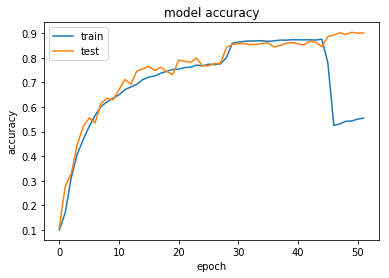

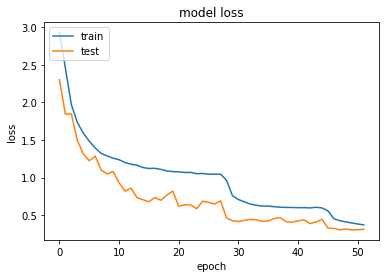

In [0]:
# Save model, plots and history
save(model, history, 'res-net-28-2-1hr-dropout-IS-superRes8x8', True)

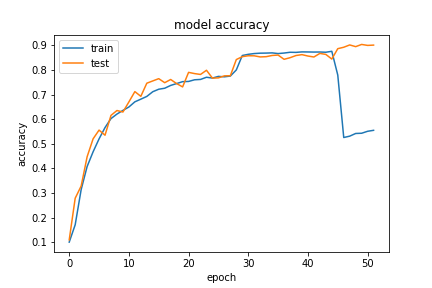

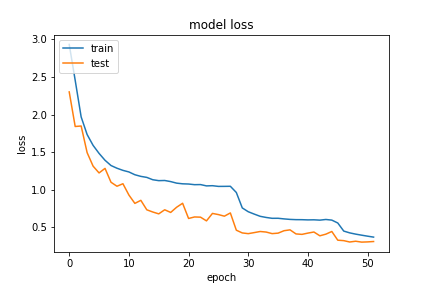

In [0]:
# Load model and draw plots 
path = "gdrive/My Drive/"
file_name = "res-net-28-2-1hr-dropout-IS-superRes8x8"
model = load_model(path + file_name + ".h5", custom_objects = {'LayerNormalization' : LayerNormalization})

# Display Saved plots
listOfImageNames = [path + file_name + "-acc.png",
                    path + file_name + "-loss.png"]

for imageName in listOfImageNames:
    display(Image(filename=imageName))
    
# Load history
history = np.load(path + file_name + "-history.npy")

### Wide ResNet (28-2) with dropout and without IS for max time of 1 hr on the output of ESRGAN (8x8 -> 32x32)

In [44]:
args = Args(depth = 28, width = 2, presample = 3.0, batch_size = 128, time_budget = 1, dropout = 0.3, useIS = False)
model, history = build_wide_res(args, ds_super_res)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
layer_normalization_1 (LayerNor (None, 32, 32, 16)   17          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activat

In [45]:
# Test the model
x_test, y_test = ds_super_res.test_data[:]
eval_model(model, x_test, y_test)

10000/10000 [==============================] - 8s 841us/step
Test loss: 0.6631258937835693
Test accuracy: 0.8385


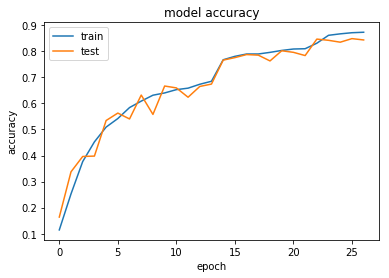

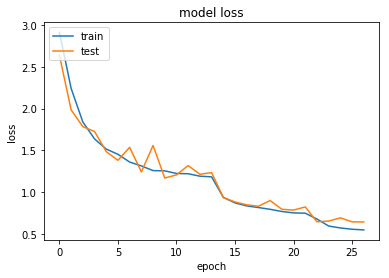

In [46]:
# Save model, plots and history
save(model, history, 'res-net-28-2-1hr-dropout-noIS-superRes8x8', False)

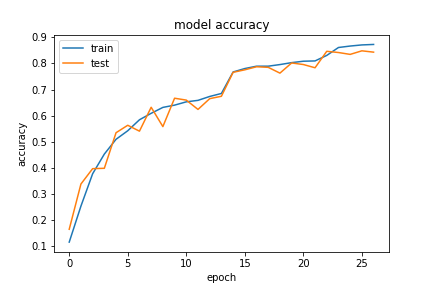

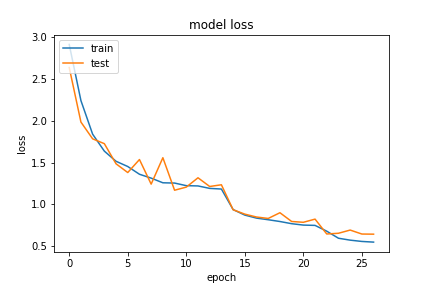

In [47]:
# Load model and draw plots 
path = "gdrive/My Drive/"
file_name = "res-net-28-2-1hr-dropout-noIS-superRes8x8"
model = load_model(path + file_name + ".h5", custom_objects = {'LayerNormalization' : LayerNormalization})

# Display Saved plots
listOfImageNames = [path + file_name + "-acc.png",
                    path + file_name + "-loss.png"]

for imageName in listOfImageNames:
    display(Image(filename=imageName))
    
# Load history
history = np.load(path + file_name + "-history.npy")

# Evaluation Plots

In [0]:
path = "gdrive/My Drive/"
file_name = "res-net-28-2-1hr-dropout-IS"
h1 = np.load(path + file_name + "-history.npy")

file_name = "res-net-28-2-1hr-dropout-noIS"
h2 = np.load(path + file_name + "-history.npy")

file_name = "res-net-28-2-1hr-nodropout-IS"
h3 = np.load(path + file_name + "-history.npy")

file_name = "res-net-28-2-1hr-nodropout-noIS"
h4 = np.load(path + file_name + "-history.npy")

file_name = "res-net-28-2-1hr-dropout-IS-superRes8x8"
h5 = np.load(path + file_name + "-history.npy")

# Generate epoch array
epochs = []
for i in range(min(h1.shape[1], h2.shape[1], h3.shape[1], h4.shape[1], h5.shape[1])):
  epochs.append(i)
epochs = np.array(epochs) 

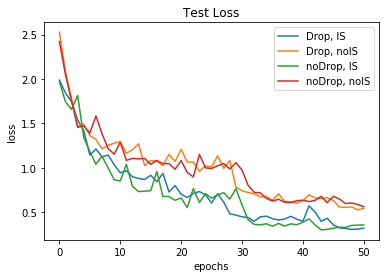

In [32]:
# Comparison of test loss (note: here test loss is the validation loss as the val set passed to Keras is the test set)            
row = 3 # For test loss
plt.plot(epochs, h1[row, :epochs[-1] + 1])
plt.plot(epochs, h2[row, :epochs[-1] + 1])
plt.plot(epochs, h3[row, :epochs[-1] + 1])
plt.plot(epochs, h4[row, :epochs[-1] + 1])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Test Loss')
plt.legend(['Drop, IS', 'Drop, noIS', 'noDrop, IS', 'noDrop, noIS'])
plt.savefig('test_loss.png')
plt.show()

files.download('test_loss.png')

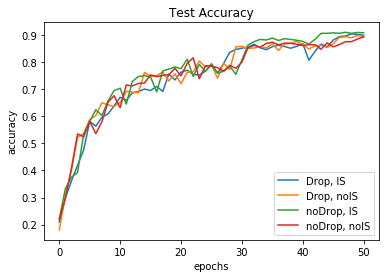

In [33]:
# Comparison of test accuracy
row = 1 # For test acc
plt.plot(epochs, h1[row, :epochs[-1] + 1])
plt.plot(epochs, h2[row, :epochs[-1] + 1])
plt.plot(epochs, h3[row, :epochs[-1] + 1])
plt.plot(epochs, h4[row, :epochs[-1] + 1])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Test Accuracy')
plt.legend(['Drop, IS', 'Drop, noIS', 'noDrop, IS', 'noDrop, noIS'])
plt.savefig('test_acc.png')
plt.show()

files.download('test_acc.png')

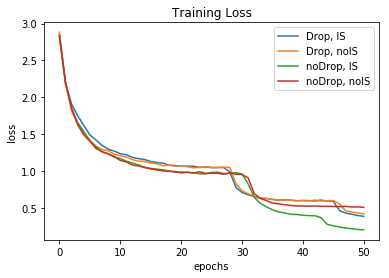

In [34]:
# Comparison of train loss
row = 2 # For train loss
plt.plot(epochs, h1[row, :epochs[-1] + 1])
plt.plot(epochs, h2[row, :epochs[-1] + 1])
plt.plot(epochs, h3[row, :epochs[-1] + 1])
plt.plot(epochs, h4[row, :epochs[-1] + 1])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Training Loss')
plt.legend(['Drop, IS', 'Drop, noIS', 'noDrop, IS', 'noDrop, noIS'])
plt.savefig('train_loss.png')
plt.show()

files.download('train_loss.png')

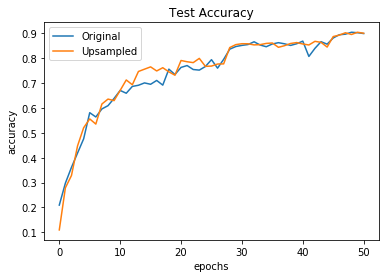

In [35]:
# Comparison with upsampled CIFAR10 (with dropout and with IS)
row = 1 # test acc
plt.plot(epochs, h1[row, :epochs[-1] + 1])
plt.plot(epochs, h5[row, :epochs[-1] + 1])
plt.legend(['Original', 'Upsampled'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Test Accuracy')
plt.savefig('test_acc_upsamp.png')
plt.show()

files.download('test_acc_upsamp.png')